In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib_venn import venn2

import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
import gffutils

pd.set_option("display.max_rows", 500)

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_3/inputs/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_3/inputs/'

# Read in data

In [3]:
hek_counts = pd.read_csv(os.path.join(input_dir, 'GSE112353_HEK_count_table.txt'), sep='\t')
hek_counts.head()

,external_transcript_name,transcript_biotype,ensembl_transcript_id,ensembl_gene_id,transcript_length,l_5utr,l_cds,l_3utr,ribolace_HEK_1,ribolace_HEK_2,riboseq_HEK_1,riboseq_HEK_2
0,5_8S_rRNA.1-201,rRNA,ENST00000614365,ENSG00000275877,152,0,0,0,1,1,5,1
1,5S_rRNA.1-201,rRNA,ENST00000364415,ENSG00000201285,116,0,0,0,0,0,0,0
2,7SK.6-201,misc_RNA,ENST00000603504,ENSG00000271394,247,0,0,0,5,51,9,6
3,A1BG-001,protein_coding,ENST00000263100,ENSG00000121410,1722,62,1488,172,6,4,4,10
4,A1BG-002,retained_intron,ENST00000595014,ENSG00000121410,2301,0,0,0,5,3,13,11


In [4]:
def get_avg_ribolace_counts(row):
    """just returns the avg of two reps."""
    return (int(row['ribolace_HEK_1']) + int(row['ribolace_HEK_2']))/2.

def get_avg_riboseq_counts(row):
    """just returns the avg of two reps."""
    return (int(row['riboseq_HEK_1']) + int(row['riboseq_HEK_2']))/2.

hek_counts['avg_ribolace'] = hek_counts.apply(get_avg_ribolace_counts, axis=1)
hek_counts['avg_riboseq'] = hek_counts.apply(get_avg_riboseq_counts, axis=1)
hek_counts = hek_counts[['ensembl_gene_id','transcript_biotype','avg_ribolace','avg_riboseq']]
hek_counts.head()

,ensembl_gene_id,transcript_biotype,avg_ribolace,avg_riboseq
0,ENSG00000275877,rRNA,1.0,3.0
1,ENSG00000201285,rRNA,0.0,0.0
2,ENSG00000271394,misc_RNA,28.0,7.5
3,ENSG00000121410,protein_coding,5.0,7.0
4,ENSG00000121410,retained_intron,4.0,12.0


# Load EPKM table at different confidence levels - 
- should be labeled in the filename.
- (previous) higher confidence levels may skew EPKM since we're effectively filtering out the "edit depth" variable. On the surface it doesn't seem to matter, but it is something to keep in mind when using EPKM. This makes it "edits per kilobase total-edits"
- (amended) use the 'mapped reads' to normalize depth of coverage. So "EPKM" literally means "edits per kilobase mapped"

In [6]:
epkm = pd.read_csv('/home/bay001/projects/kris_apobec_20200121/staged_for_deletion/no_utr3_edit_counts_epkm_at_conf_0.5.txt', sep='\t', index_col=0)
del epkm['Genename']
epkm.head()

,Geneid,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/ABCE1-0_S1_L001_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/ABCE1-1000_S15_L002_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/ABCE1-50_S8_L001_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/ApoControl-0_S7_L001_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/ApoControl-1000_S21_L002_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/ApoControl-50_S14_L002_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/ETF1-0_S2_L001_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/ETF1-1000_S16_L002_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/ETF1-50_S9_L001_R1_001,...,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/GSTP1-50_S10_L001_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/RBFOX2-0_S6_L001_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/RBFOX2-1000_S20_L002_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/RBFOX2-50_S13_L002_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/RPS2-0_S4_L001_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/RPS2-1000_S18_L002_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/RPS2-50_S11_L001_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/RPS3-0_S5_L001_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/RPS3-1000_S19_L002_R1_001,/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/RPS3-50_S12_L001_R1_001
0,ENSG00000223972.4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,ENSG00000227232.4,0.023325,0.034916,0.04522,0.019238,0.018273,0.042243,0.089798,0.030256,0.040597,...,0.01784,0.028078,0.01711,0.04151,0.037489,0.009921,0.046622,0.030372,0.061936,0.0
2,ENSG00000243485.2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,ENSG00000237613.2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,ENSG00000268020.2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [7]:
def gene_id_to_protein_coding(db):
    """
    returns whether or not a gene is protein coding or not.
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id']
        try:
            gene_name_dict[gene_id] = gene.attributes['gene_type'][0]
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict
    
db_file = '/projects/ps-yeolab4/genomes/hg19/gencode_v19/gencode.v19.annotation.gtf.db'
DATABASE = gffutils.FeatureDB(db_file)
gene_id_to_pc = gene_id_to_protein_coding(DATABASE)
print(gene_id_to_pc['ENSG00000100320.18'])

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


protein_coding


In [8]:
def get_gene_is_pc(row, d=gene_id_to_pc):
    """
    Helper function that uses the gene_id_to_pc dictionary to assign whether or not
    a gene is protein coding. Returns 'unannotated' in case the geneid doesn't exist
    in the dictionary.
    """
    try:
        return d[row['Geneid']]
    except KeyError:
        return 'unannotated'
    
epkm['gene_type'] = epkm.apply(get_gene_is_pc, axis=1)
epkm.columns = [c.replace('/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_lenti_dox_bulk_rnaseq/outputs/', '') for c in epkm.columns]
print(epkm.columns)
epkm.head()

Index(['Geneid', 'ABCE1-0_S1_L001_R1_001', 'ABCE1-1000_S15_L002_R1_001',
       'ABCE1-50_S8_L001_R1_001', 'ApoControl-0_S7_L001_R1_001',
       'ApoControl-1000_S21_L002_R1_001', 'ApoControl-50_S14_L002_R1_001',
       'ETF1-0_S2_L001_R1_001', 'ETF1-1000_S16_L002_R1_001',
       'ETF1-50_S9_L001_R1_001', 'GSTP1-0_S3_L001_R1_001',
       'GSTP1-1000_S17_L002_R1_001', 'GSTP1-50_S10_L001_R1_001',
       'RBFOX2-0_S6_L001_R1_001', 'RBFOX2-1000_S20_L002_R1_001',
       'RBFOX2-50_S13_L002_R1_001', 'RPS2-0_S4_L001_R1_001',
       'RPS2-1000_S18_L002_R1_001', 'RPS2-50_S11_L001_R1_001',
       'RPS3-0_S5_L001_R1_001', 'RPS3-1000_S19_L002_R1_001',
       'RPS3-50_S12_L001_R1_001', 'gene_type'],
      dtype='object')


,Geneid,ABCE1-0_S1_L001_R1_001,ABCE1-1000_S15_L002_R1_001,ABCE1-50_S8_L001_R1_001,ApoControl-0_S7_L001_R1_001,ApoControl-1000_S21_L002_R1_001,ApoControl-50_S14_L002_R1_001,ETF1-0_S2_L001_R1_001,ETF1-1000_S16_L002_R1_001,ETF1-50_S9_L001_R1_001,...,RBFOX2-0_S6_L001_R1_001,RBFOX2-1000_S20_L002_R1_001,RBFOX2-50_S13_L002_R1_001,RPS2-0_S4_L001_R1_001,RPS2-1000_S18_L002_R1_001,RPS2-50_S11_L001_R1_001,RPS3-0_S5_L001_R1_001,RPS3-1000_S19_L002_R1_001,RPS3-50_S12_L001_R1_001,gene_type
0,ENSG00000223972.4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,pseudogene
1,ENSG00000227232.4,0.023325,0.034916,0.04522,0.019238,0.018273,0.042243,0.089798,0.030256,0.040597,...,0.028078,0.01711,0.04151,0.037489,0.009921,0.046622,0.030372,0.061936,0.0,pseudogene
2,ENSG00000243485.2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,lincRNA
3,ENSG00000237613.2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,lincRNA
4,ENSG00000268020.2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,pseudogene


# Let's focus just on RPS3-1000 for now

In [9]:
epkm_rps3 = epkm[['Geneid','RPS3-1000_S19_L002_R1_001','gene_type']]
epkm_rps3[epkm_rps3['Geneid']=='ENSG00000080824.14']

,Geneid,RPS3-1000_S19_L002_R1_001,gene_type
39711,ENSG00000080824.14,0.072591,protein_coding


# We need to do some additional wrangling here (riboseq/ribolace data is hg38 and uses ensembl geneIDs, while our EPKM table is hg19/gencode)
- Let's plan to convert the Gencode IDs to Ensembl-style and intersect the GeneIDs. Hopefully we get decent overlap between hg38/hg19

In [10]:
try:
    epkm_rps3['ensembl_Geneid'] = epkm_rps3['Geneid'].apply(lambda x: x.split('.')[0])
    del epkm_rps3['Geneid']
except KeyError:
    pass

epkm_rps3.set_index('ensembl_Geneid', inplace=True)
epkm_rps3.sort_values(by='RPS3-1000_S19_L002_R1_001', ascending=False).head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,RPS3-1000_S19_L002_R1_001,gene_type
ensembl_Geneid,,
ENSG00000244398,1.599912,pseudogene
ENSG00000250321,1.356263,pseudogene
ENSG00000240036,1.152463,pseudogene
ENSG00000227081,1.146365,pseudogene
ENSG00000235174,1.131669,pseudogene


# Remove any non-protein-coding genes and split the ribosome data into quartiles
- ok we'll need to just use the highest (avg) counts per gene since these values are per-transcript 

In [11]:
# only protein coding genes for EPKM table
print(epkm_rps3.shape[0])
epkm_rps3 = epkm_rps3[epkm_rps3['gene_type']=='protein_coding']
print(epkm_rps3.shape[0])

57614
20309


# Check that we're getting high EPKM values for genes that Kris is seeing:

In [12]:
epkm_rps3.sort_values(by='RPS3-1000_S19_L002_R1_001', ascending=False).head()

,RPS3-1000_S19_L002_R1_001,gene_type
ensembl_Geneid,,
ENSG00000261514,0.862856,protein_coding
ENSG00000187145,0.782884,protein_coding
ENSG00000182117,0.772735,protein_coding
ENSG00000177954,0.714738,protein_coding
ENSG00000204899,0.678815,protein_coding


In [13]:
epkm_rps3.loc[['ENSG00000096384', 'ENSG00000080824', 'ENSG00000075624']]

,RPS3-1000_S19_L002_R1_001,gene_type
ensembl_Geneid,,
ENSG00000096384,0.121584,protein_coding
ENSG00000080824,0.072591,protein_coding
ENSG00000075624,0.043027,protein_coding


In [14]:
# only protein coding genes for riboseq table
print(hek_counts.shape[0]) # all geneids
hek_counts = hek_counts[hek_counts['transcript_biotype']=='protein_coding']
print(hek_counts.shape[0]) # only protein-coding geneids
hek_counts[hek_counts['ensembl_gene_id'].isin(['ENSG00000096384', 'ENSG00000080824', 'ENSG00000075624'])]

196147
79971


,ensembl_gene_id,transcript_biotype,avg_ribolace,avg_riboseq
6119,ENSG00000075624,protein_coding,545.0,1265.5
6126,ENSG00000075624,protein_coding,171.5,454.0
6127,ENSG00000075624,protein_coding,95.0,253.0
6128,ENSG00000075624,protein_coding,86.0,203.5
6130,ENSG00000075624,protein_coding,108.0,267.0
70542,ENSG00000080824,protein_coding,412.5,910.0
70543,ENSG00000080824,protein_coding,438.5,1025.0
70546,ENSG00000080824,protein_coding,79.5,160.0
70551,ENSG00000080824,protein_coding,0.5,4.0
70558,ENSG00000096384,protein_coding,501.5,1285.5


In [18]:
# Just get the highest tx counts per gene
riboseq_hek_counts = hek_counts[['ensembl_gene_id','avg_riboseq']].sort_values('ensembl_gene_id', ascending=False)
riboseq_hek_counts = riboseq_hek_counts.groupby('ensembl_gene_id').max()
print(riboseq_hek_counts.shape[0])
riboseq_hek_counts.head()

19724


,avg_riboseq
ensembl_gene_id,
ENSG00000000003,125.0
ENSG00000000005,0.5
ENSG00000000419,35.5
ENSG00000000457,21.0
ENSG00000000460,20.0


In [19]:
riboseq_hek_counts.loc[['ENSG00000096384', 'ENSG00000080824', 'ENSG00000075624']]

,avg_riboseq
ensembl_gene_id,
ENSG00000096384,1285.5
ENSG00000080824,1025.0
ENSG00000075624,1265.5


In [20]:
riboseq_hek_counts[riboseq_hek_counts['avg_riboseq']==5878.0]

,avg_riboseq
ensembl_gene_id,
ENSG00000133316,5878.0


In [16]:
riboseq_hek_counts['pct'] = riboseq_hek_counts.rank(pct=True)

In [17]:
q1 = riboseq_hek_counts[(riboseq_hek_counts['pct'] <= 1) & (riboseq_hek_counts['pct'] > 0.75)][['avg_riboseq']]
q2 = riboseq_hek_counts[(riboseq_hek_counts['pct'] <= 0.75) & (riboseq_hek_counts['pct'] > 0.5)][['avg_riboseq']]
q3 = riboseq_hek_counts[(riboseq_hek_counts['pct'] <= 0.5) & (riboseq_hek_counts['pct'] > 0.25)][['avg_riboseq']]
q4 = riboseq_hek_counts[(riboseq_hek_counts['pct'] <= 0.25) & (riboseq_hek_counts['pct'] > 0.0)][['avg_riboseq']]

c = 0
print("Number of genes in bins: ")
for q in [q1, q2, q3, q4]:
    c += 1
    print("q{}: {}".format(c, q.shape[0]), sep=' ', end=' ')

Number of genes in bins: 
q1: 4934 q2: 4913 q3: 4856 q4: 5021 

# join epkm with riboseq data
- check the numbers, make sure we have sufficient overlap

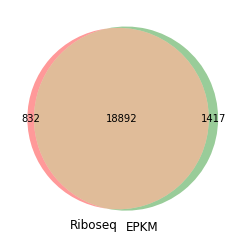

In [18]:
venn2([set(riboseq_hek_counts.index), set(epkm_rps3.index)], ['Riboseq', 'EPKM'])

# Highest occupancy values that are NOT included in this analysis!

In [19]:
excl = riboseq_hek_counts.loc[set(riboseq_hek_counts.index).difference(set(epkm_rps3.index))].sort_values(by='avg_riboseq', ascending=False)
excl.head()

,avg_riboseq,pct
ensembl_gene_id,,
ENSG00000274267,10985.5,1.000000
ENSG00000278828,10384.0,0.999899
ENSG00000272196,8112.5,0.999645
ENSG00000276966,4479.0,0.999138
ENSG00000273542,4255.0,0.999087


# Most of the (incl in Riboseq but excluded in EPKM) values fall into the low occupancy bin:

Text(0.5,1,'Number of EXCLUDED (in Ribo, not in EPKM) genes. Where are they?')

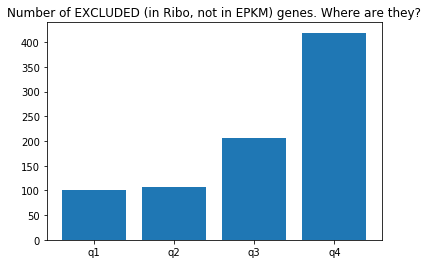

In [20]:
q1_excl = excl[(excl['pct'] <= 1) & (excl['pct'] > 0.75)][['avg_riboseq']]
q2_excl = excl[(excl['pct'] <= 0.75) & (excl['pct'] > 0.5)][['avg_riboseq']]
q3_excl = excl[(excl['pct'] <= 0.5) & (excl['pct'] > 0.25)][['avg_riboseq']]
q4_excl = excl[(excl['pct'] <= 0.25) & (excl['pct'] > 0.0)][['avg_riboseq']]
plt.bar(['q1','q2','q3','q4'], [q1_excl.shape[0], q2_excl.shape[0], q3_excl.shape[0], q4_excl.shape[0]])
plt.title("Number of EXCLUDED (in Ribo, not in EPKM) genes. Where are they?")

# Most of the (incl in RPKM but excluded in Riboseq) have low EPKM #s

(1417,)


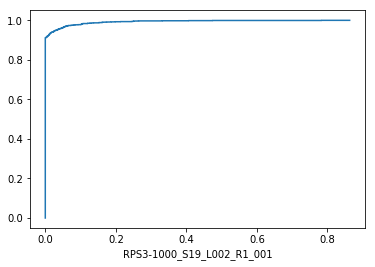

In [21]:
excl = epkm_rps3.loc[set(epkm_rps3.index).difference(set(riboseq_hek_counts.index))]['RPS3-1000_S19_L002_R1_001']
# excl[len(excl)] = excl.iloc[-1]
excl = excl.sort_values()
print(excl.shape)
cum_dist = np.linspace(0.,1.,len(excl))
cdf = pd.Series(cum_dist, index=excl)
cdf.plot(drawstyle='steps')

In [22]:
excl.head()

ensembl_Geneid
ENSG00000268996    0.0
ENSG00000269795    0.0
ENSG00000108753    0.0
ENSG00000129282    0.0
ENSG00000204814    0.0
Name: RPS3-1000_S19_L002_R1_001, dtype: float64

before/after dropping entries that do not exist in hg19/gencode 19: 4934 -> 4833
before/after dropping entries that do not exist in hg19/gencode 19: 4913 -> 4807
before/after dropping entries that do not exist in hg19/gencode 19: 4856 -> 4650
before/after dropping entries that do not exist in hg19/gencode 19: 5021 -> 4602


/home/bay001/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


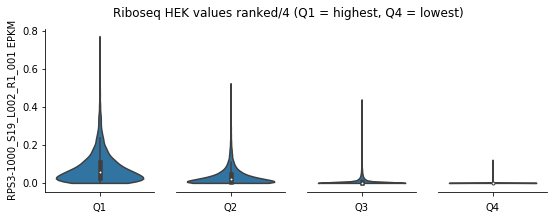

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
qs = [q1, q2, q3, q4]
for c in range(4):
    merged = pd.merge(qs[c], epkm_rps3, how='left', left_index=True, right_index=True)
    before_size = merged.shape[0]
    merged.dropna(inplace=True)
    after_size = merged.shape[0]
    print("before/after dropping entries that do not exist in hg19/gencode 19: {} -> {}".format(before_size, after_size))
    # merged['RPS3-1000_S19_L002_R1_001'].plot(kind='box', ax=axs[c], label='Q{}'.format(c+1))
    sns.violinplot(merged['RPS3-1000_S19_L002_R1_001'], ax=axs[c], label='Q{}'.format(c+1), orient='v', cut=0)
    axs[c].set_xlabel('Q{}'.format(c+1))
    sns.despine()
for c in range(3):
    axs[c+1].get_yaxis().set_visible(False)
    sns.despine(ax=axs[c+1], top=True, bottom=False, left=True, right=True)
axs[0].set_ylabel('RPS3-1000_S19_L002_R1_001 EPKM')
plt.suptitle("Riboseq HEK values ranked/4 (Q1 = highest, Q4 = lowest)")
fig.savefig(os.path.join(output_dir, 'boxplot_q_vs_epkm.png'))

# Log EPKM values?

In [24]:
epkm_rps3['log2(RPS3-1000_S19_L002_R1_001+1)'] = np.log2(epkm_rps3['RPS3-1000_S19_L002_R1_001'] + 1)
epkm_rps3.head()

,RPS3-1000_S19_L002_R1_001,gene_type,log2(RPS3-1000_S19_L002_R1_001+1)
ensembl_Geneid,,,
ENSG00000186092,0.0,protein_coding,0.0
ENSG00000237683,0.0,protein_coding,0.0
ENSG00000235249,0.0,protein_coding,0.0
ENSG00000185097,0.0,protein_coding,0.0
ENSG00000269831,0.0,protein_coding,0.0


before/after dropping entries that do not exist in hg19/gencode 19: 4934 -> 4833
before/after dropping entries that do not exist in hg19/gencode 19: 4913 -> 4807
before/after dropping entries that do not exist in hg19/gencode 19: 4856 -> 4650
before/after dropping entries that do not exist in hg19/gencode 19: 5021 -> 4602


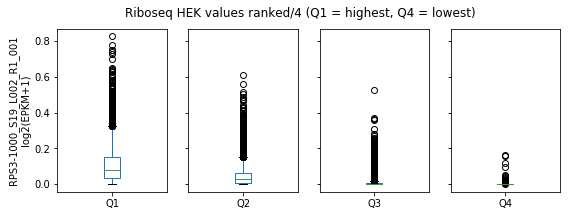

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
qs = [q1, q2, q3, q4]
for c in range(4):
    merged = pd.merge(qs[c], epkm_rps3, how='left', left_index=True, right_index=True)
    before_size = merged.shape[0]
    merged.dropna(inplace=True)
    after_size = merged.shape[0]
    print("before/after dropping entries that do not exist in hg19/gencode 19: {} -> {}".format(before_size, after_size))
    merged['log2(RPS3-1000_S19_L002_R1_001+1)'].plot(kind='box', ax=axs[c], label='Q{}'.format(c+1))
axs[0].set_ylabel('RPS3-1000_S19_L002_R1_001\nlog2(EPKM+1)')
plt.suptitle("Riboseq HEK values ranked/4 (Q1 = highest, Q4 = lowest)")
fig.savefig(os.path.join(output_dir, 'boxplot_q_vs_l2epkm.png'))

# Ribolace?

In [26]:
# Just get the highest tx counts per gene
ribolace_hek_counts = hek_counts[['ensembl_gene_id','avg_ribolace']].sort_values('ensembl_gene_id', ascending=False)
ribolace_hek_counts = ribolace_hek_counts.groupby('ensembl_gene_id').max()
print(ribolace_hek_counts.shape[0])
ribolace_hek_counts.head()

19724


,avg_ribolace
ensembl_gene_id,
ENSG00000000003,44.0
ENSG00000000005,0.0
ENSG00000000419,20.0
ENSG00000000457,13.0
ENSG00000000460,7.0


In [27]:
ribolace_hek_counts['pct'] = ribolace_hek_counts.rank(pct=True)

In [28]:
q1 = ribolace_hek_counts[(ribolace_hek_counts['pct'] <= 1) & (ribolace_hek_counts['pct'] > 0.75)][['avg_ribolace']]
q2 = ribolace_hek_counts[(ribolace_hek_counts['pct'] <= 0.75) & (ribolace_hek_counts['pct'] > 0.5)][['avg_ribolace']]
q3 = ribolace_hek_counts[(ribolace_hek_counts['pct'] <= 0.5) & (ribolace_hek_counts['pct'] > 0.25)][['avg_ribolace']]
q4 = ribolace_hek_counts[(ribolace_hek_counts['pct'] <= 0.25) & (ribolace_hek_counts['pct'] > 0.0)][['avg_ribolace']]

c = 0
print("Number of genes in bins: ")
for q in [q1, q2, q3, q4]:
    c += 1
    print("q{}: {}".format(c, q.shape[0]), sep=' ', end=' ')

Number of genes in bins: 
q1: 4910 q2: 5076 q3: 4424 q4: 5314 

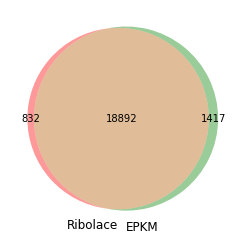

In [29]:
venn2([set(ribolace_hek_counts.index), set(epkm_rps3.index)], ['Ribolace', 'EPKM'])

In [30]:
excl = ribolace_hek_counts.loc[set(ribolace_hek_counts.index).difference(set(epkm_rps3.index))].sort_values(by='avg_ribolace', ascending=False)
excl.head()

,avg_ribolace,pct
ensembl_gene_id,,
ENSG00000283683,7830.5,0.999949
ENSG00000274267,4519.5,0.999696
ENSG00000278828,4294.0,0.999544
ENSG00000272196,3051.5,0.999087
ENSG00000276966,1752.0,0.998479


Text(0.5,1,'Number of EXCLUDED (in Ribo, not in EPKM) genes. Where are they?')

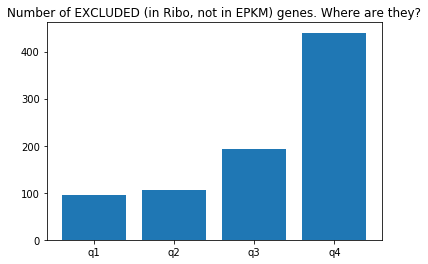

In [31]:
q1_excl = excl[(excl['pct'] <= 1) & (excl['pct'] > 0.75)][['avg_ribolace']]
q2_excl = excl[(excl['pct'] <= 0.75) & (excl['pct'] > 0.5)][['avg_ribolace']]
q3_excl = excl[(excl['pct'] <= 0.5) & (excl['pct'] > 0.25)][['avg_ribolace']]
q4_excl = excl[(excl['pct'] <= 0.25) & (excl['pct'] > 0.0)][['avg_ribolace']]
plt.bar(['q1','q2','q3','q4'], [q1_excl.shape[0], q2_excl.shape[0], q3_excl.shape[0], q4_excl.shape[0]])
plt.title("Number of EXCLUDED (in Ribo, not in EPKM) genes. Where are they?")

(1417,)


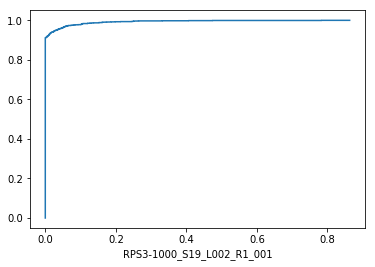

In [32]:
excl = epkm_rps3.loc[set(epkm_rps3.index).difference(set(ribolace_hek_counts.index))]['RPS3-1000_S19_L002_R1_001']
# excl[len(excl)] = excl.iloc[-1]
excl = excl.sort_values()
print(excl.shape)
cum_dist = np.linspace(0.,1.,len(excl))
cdf = pd.Series(cum_dist, index=excl)
cdf.plot(drawstyle='steps')

before/after dropping entries that do not exist in hg19/gencode 19: 4910 -> 4815
before/after dropping entries that do not exist in hg19/gencode 19: 5076 -> 4971
before/after dropping entries that do not exist in hg19/gencode 19: 4424 -> 4232
before/after dropping entries that do not exist in hg19/gencode 19: 5314 -> 4874


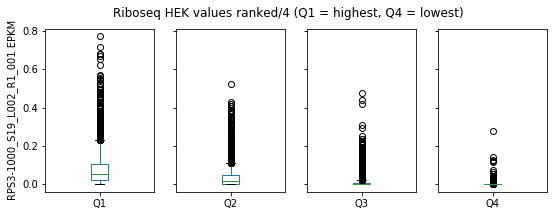

In [33]:
fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
qs = [q1, q2, q3, q4]
for c in range(4):
    merged = pd.merge(qs[c], epkm_rps3, how='left', left_index=True, right_index=True)
    before_size = merged.shape[0]
    merged.dropna(inplace=True)
    after_size = merged.shape[0]
    print("before/after dropping entries that do not exist in hg19/gencode 19: {} -> {}".format(before_size, after_size))
    merged['RPS3-1000_S19_L002_R1_001'].plot(kind='box', ax=axs[c], label='Q{}'.format(c+1))
axs[0].set_ylabel('RPS3-1000_S19_L002_R1_001 EPKM')
plt.suptitle("Riboseq HEK values ranked/4 (Q1 = highest, Q4 = lowest)")
fig.savefig(os.path.join(output_dir, 'boxplot_q_vs_epkm_ribolace.png'))

before/after dropping entries that do not exist in hg19/gencode 19: 4910 -> 4815
before/after dropping entries that do not exist in hg19/gencode 19: 5076 -> 4971
before/after dropping entries that do not exist in hg19/gencode 19: 4424 -> 4232
before/after dropping entries that do not exist in hg19/gencode 19: 5314 -> 4874


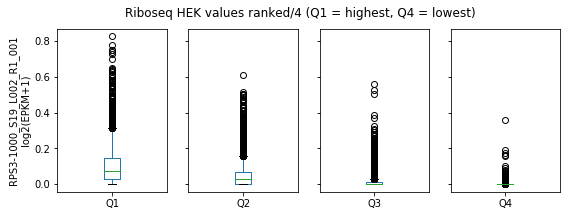

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
qs = [q1, q2, q3, q4]
for c in range(4):
    merged = pd.merge(qs[c], epkm_rps3, how='left', left_index=True, right_index=True)
    before_size = merged.shape[0]
    merged.dropna(inplace=True)
    after_size = merged.shape[0]
    print("before/after dropping entries that do not exist in hg19/gencode 19: {} -> {}".format(before_size, after_size))
    merged['log2(RPS3-1000_S19_L002_R1_001+1)'].plot(kind='box', ax=axs[c], label='Q{}'.format(c+1))
axs[0].set_ylabel('RPS3-1000_S19_L002_R1_001\nlog2(EPKM+1)')
plt.suptitle("Riboseq HEK values ranked/4 (Q1 = highest, Q4 = lowest)")
fig.savefig(os.path.join(output_dir, 'boxplot_q_vs_l2epkm_ribolace.png'))

# Ribolace/Riboseq seem like they draw the same conclusions for RPS, let's look at Fred's data and APO-only 1000
- I'll take the same code above and merge them into a single block of code, and loop over to include the other edits

### let's parse out fred's data in the same way we did for riboseq_hek_counts and ribolace_hek_counts (Note: Fred's table is filtered for gene expression (RPKM > 1))

In [35]:
fred = pd.read_excel(os.path.join(input_dir, '293_Normalized_Expression_Complete.xlsx'))
fred_x2 = fred[['Geneid','(X2poly/X2)']]
fred_x2['gene_type'] = fred_x2.apply(get_gene_is_pc, axis=1)
fred_x2 = fred_x2[fred_x2['gene_type']=='protein_coding']
fred_x2['ensembl_Geneid'] = fred_x2['Geneid'].apply(lambda x: x.split('.')[0])
del fred_x2['Geneid']
del fred_x2['gene_type']
fred_x2.set_index('ensembl_Geneid', inplace=True)

fred_x3 = fred[['Geneid','(X3poly/X3)']]
fred_x3['gene_type'] = fred_x3.apply(get_gene_is_pc, axis=1)
fred_x3 = fred_x3[fred_x3['gene_type']=='protein_coding']
fred_x3['ensembl_Geneid'] = fred_x3['Geneid'].apply(lambda x: x.split('.')[0])
del fred_x3['Geneid']
del fred_x3['gene_type']
fred_x3.set_index('ensembl_Geneid', inplace=True)

fred_x2.head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,(X2poly/X2)
ensembl_Geneid,
ENSG00000105880,1.213977
ENSG00000108797,0.270887
ENSG00000204377,0.537413
ENSG00000174938,0.984900
ENSG00000226180,0.554637


# Final analysis - all studies/combinations (using the same code as above):

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


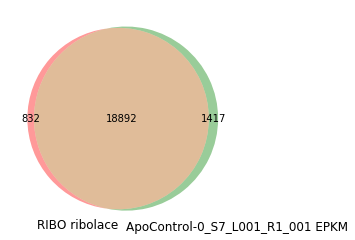

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.007950429383686307
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.008198880301926503
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.042766063044043436


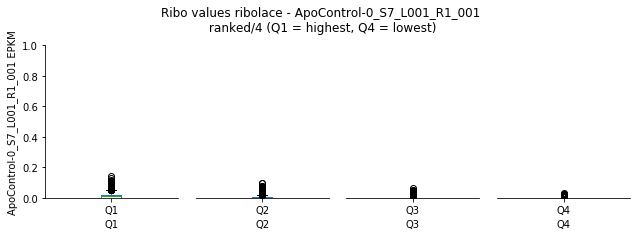

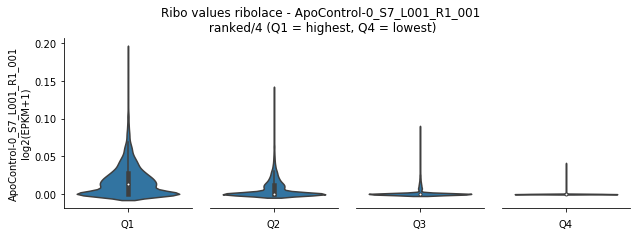

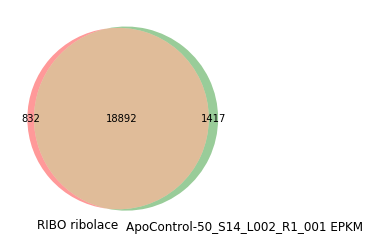

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.04364557621330485
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.009001900093994125
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.011738670792811642


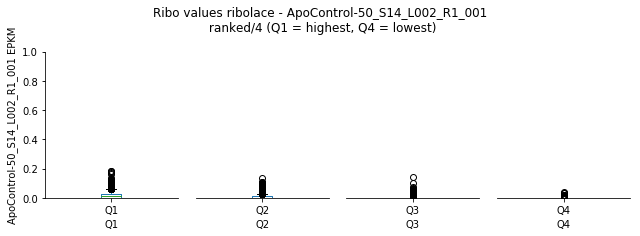

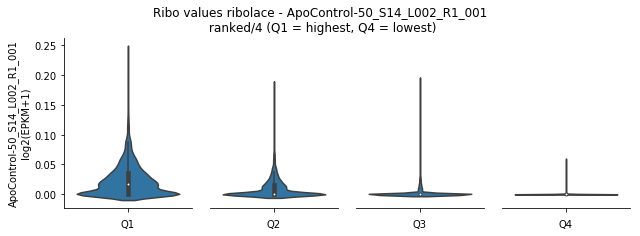

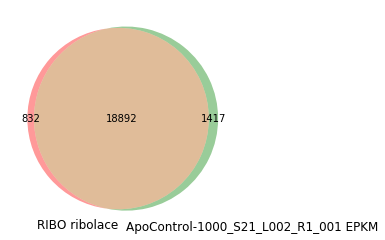

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.022655493147090845
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.007787825769312481
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.0


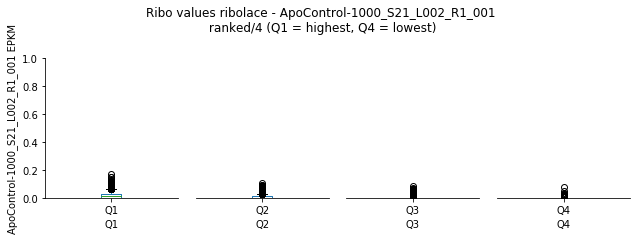

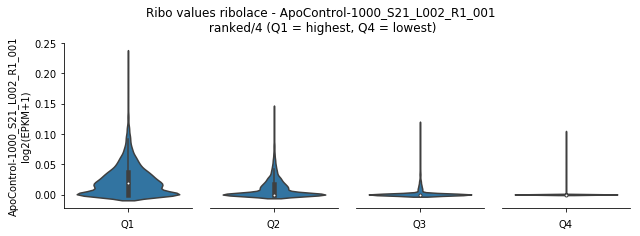

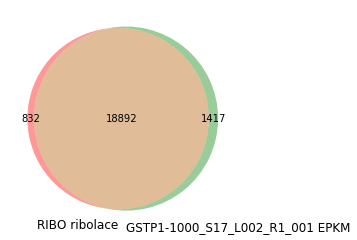

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.0532818011238779
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.01569910211685688
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.020471965870346345


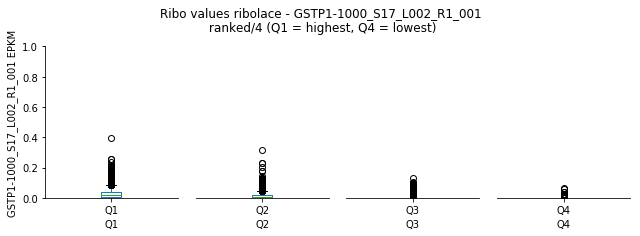

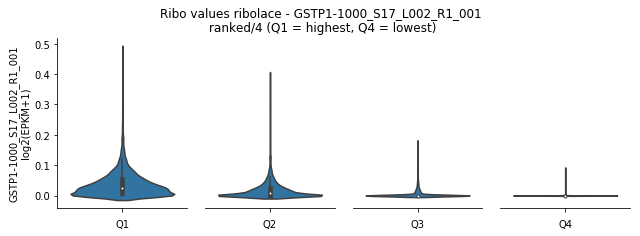

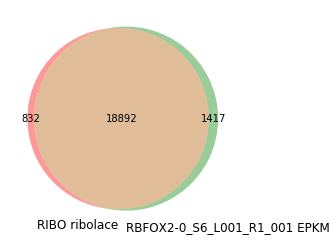

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.0
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.00797777055020415
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.020806367804929213


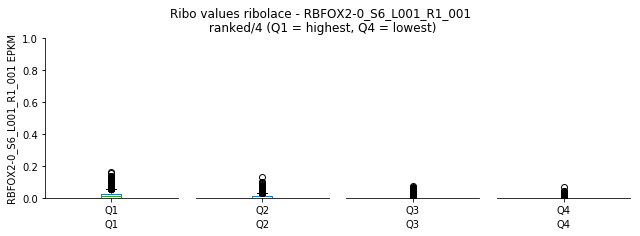

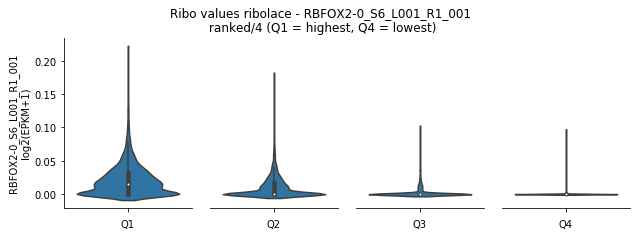

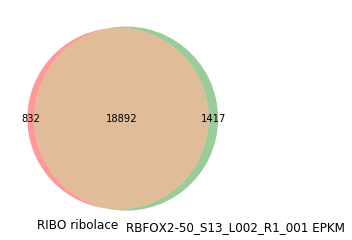

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.12866452022948852
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.05307411459466401
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.0


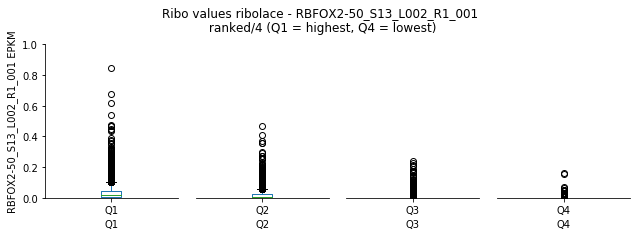

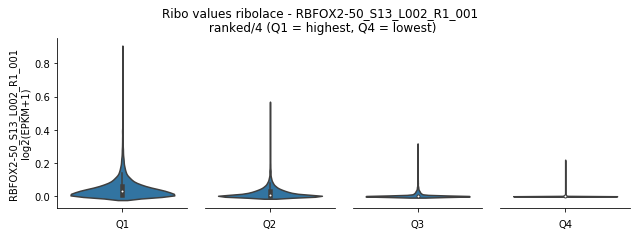

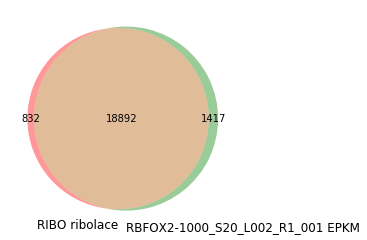

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.14142379298460445
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.07292164325768666
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.019018277362219192


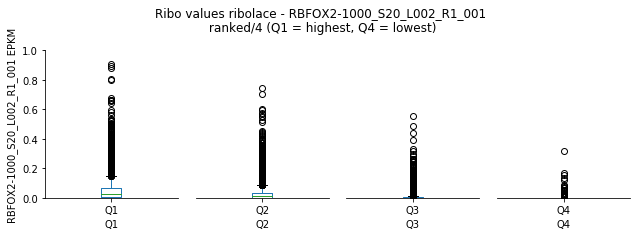

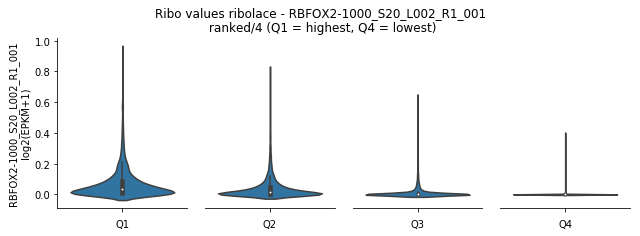

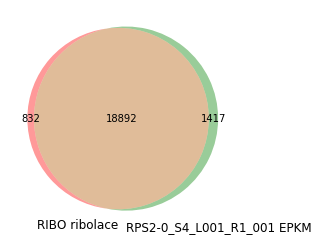

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.04131602640766795
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.042607152232907584
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.06945080042254104


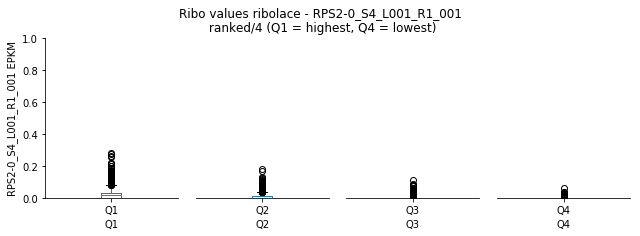

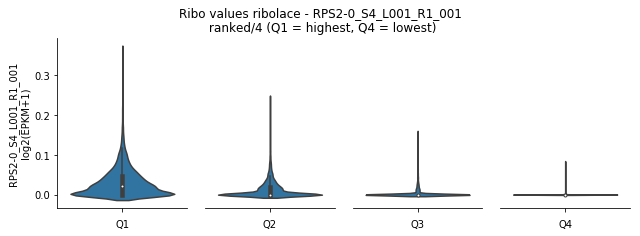

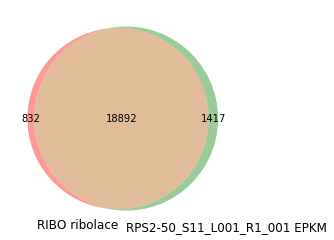

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.1618493598462628
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.04768775781184529
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.031092929490189745


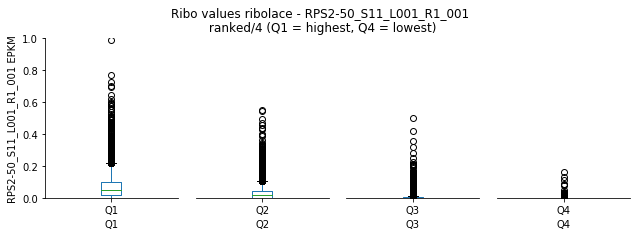

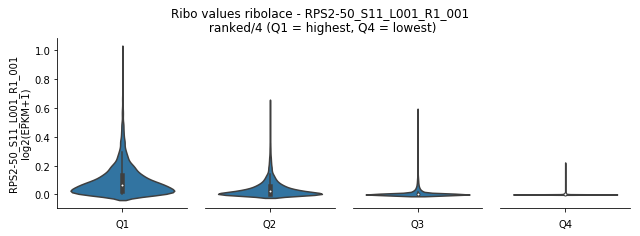

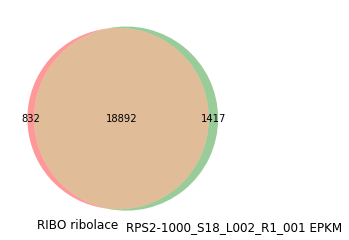

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.4674241971308377
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.21141719442595452
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.11027702237939334


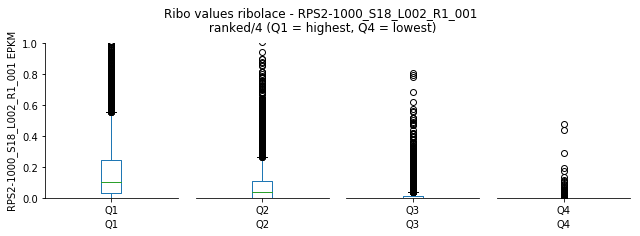

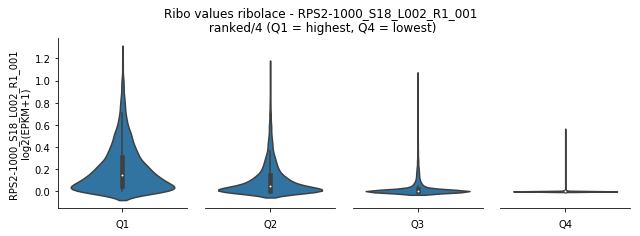

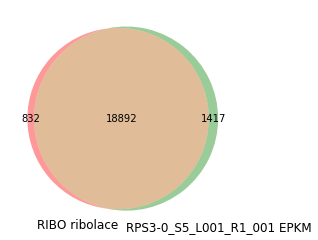

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.0
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.006472083535240594
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.025319207224190548


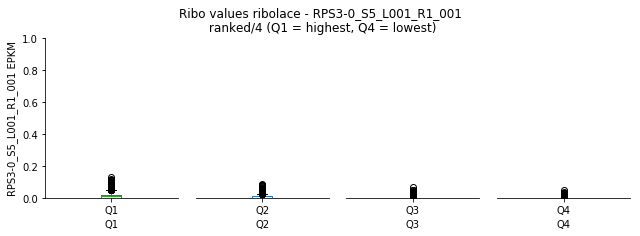

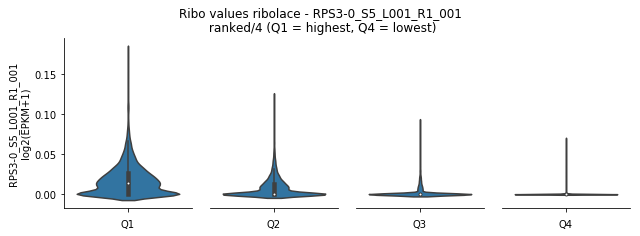

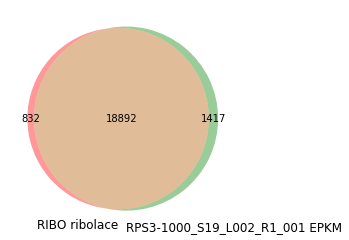

Number of genes in bins:  q1: 4910 q2: 5076 q3: 4424 q4: 5314 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 501.5 and EPKM of 0.1215842195028352
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 438.5 and EPKM of 0.07259057842027825
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 545.0 and EPKM of 0.04302712325569503


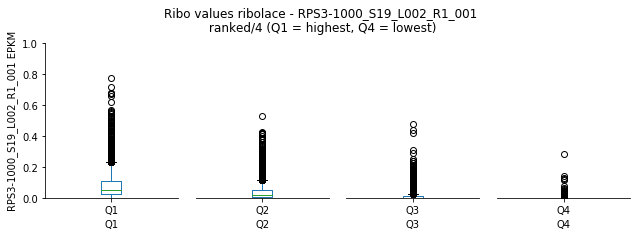

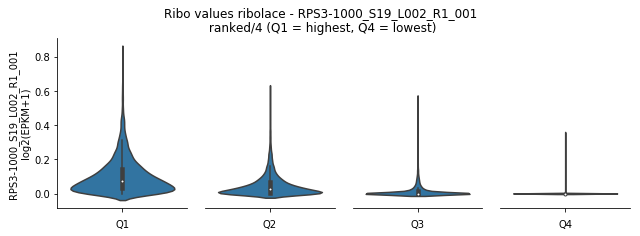

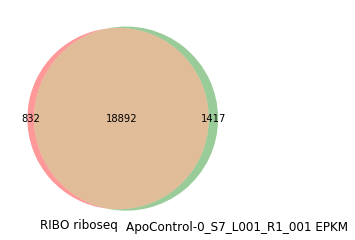

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.007950429383686307
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.008198880301926503
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.042766063044043436


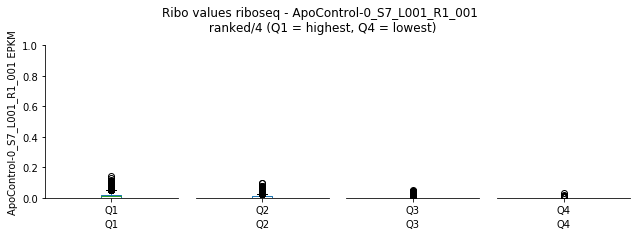

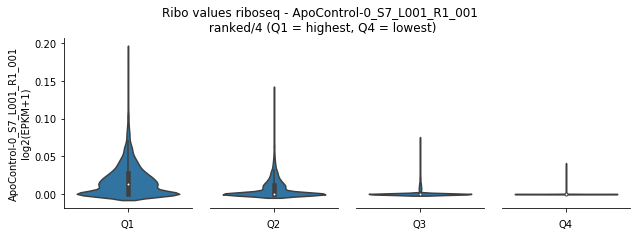

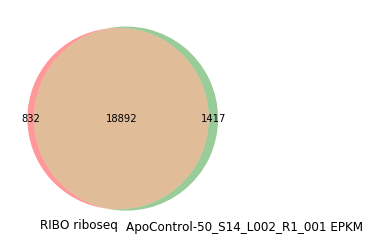

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.04364557621330485
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.009001900093994125
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.011738670792811642


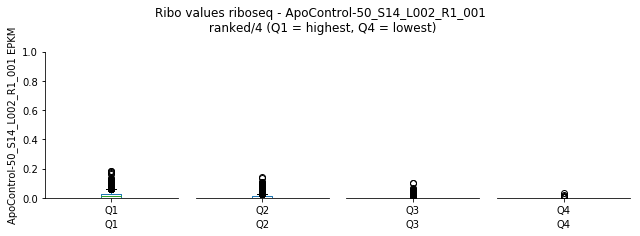

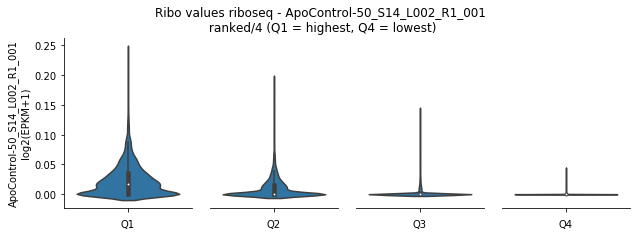

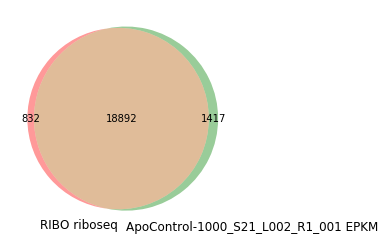

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.022655493147090845
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.007787825769312481
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.0


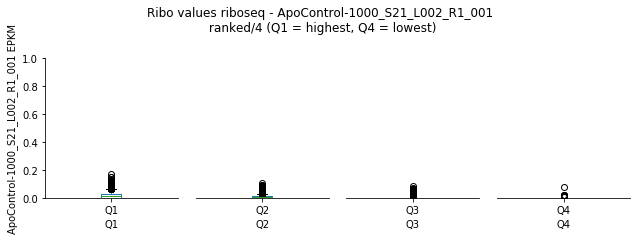

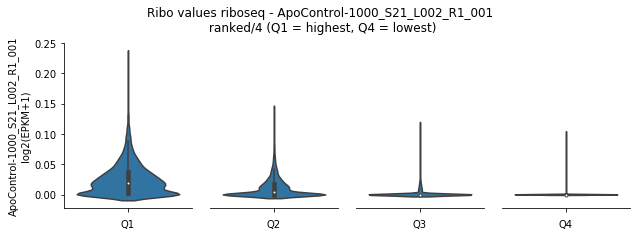

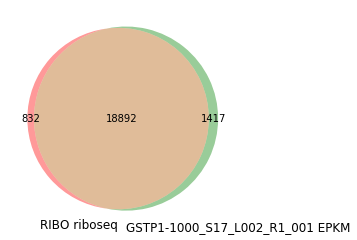

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.0532818011238779
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.01569910211685688
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.020471965870346345


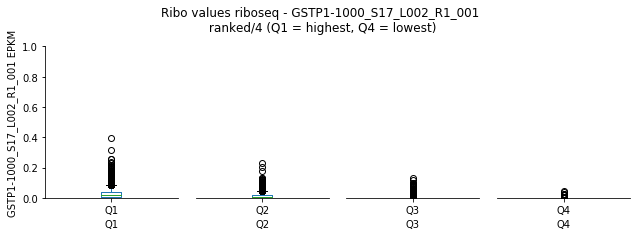

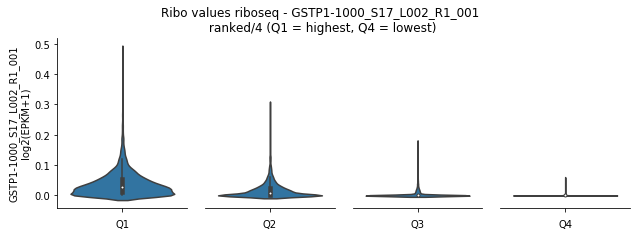

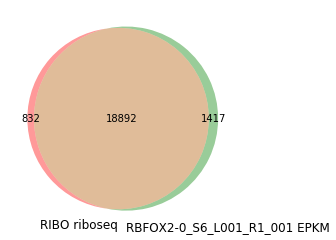

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.0
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.00797777055020415
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.020806367804929213


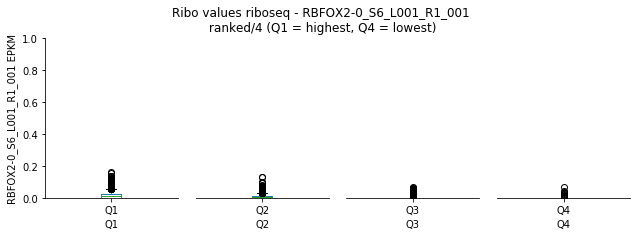

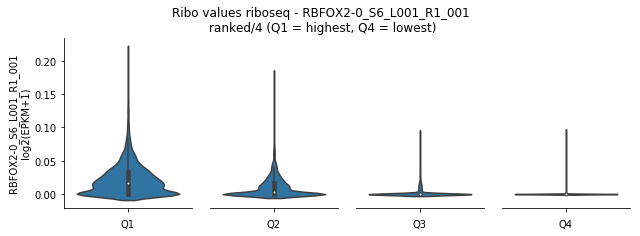

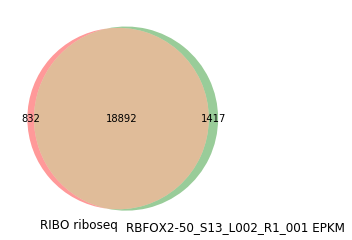

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.12866452022948852
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.05307411459466401
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.0


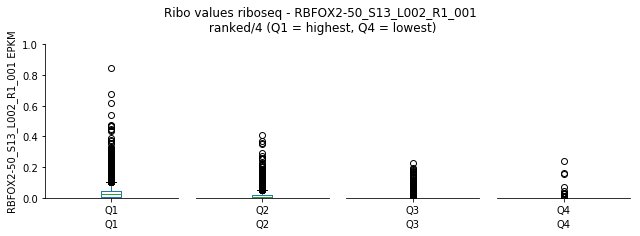

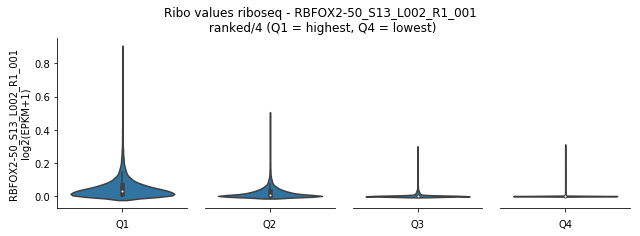

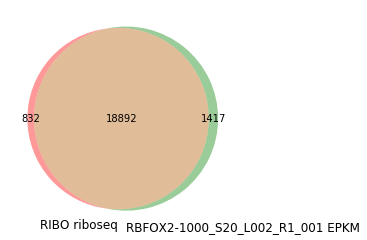

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.14142379298460445
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.07292164325768666
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.019018277362219192


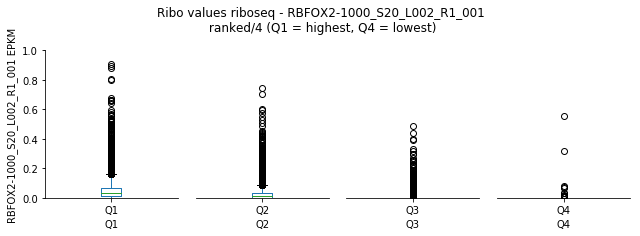

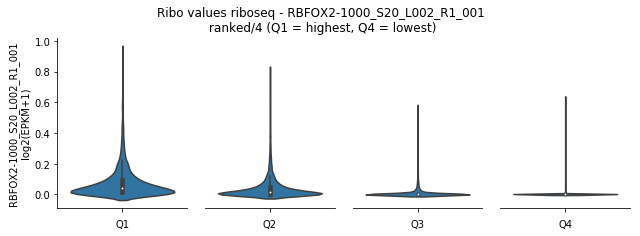

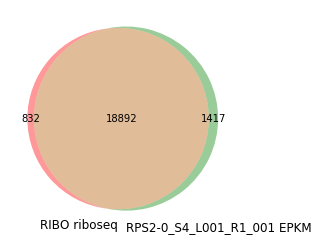

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.04131602640766795
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.042607152232907584
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.06945080042254104


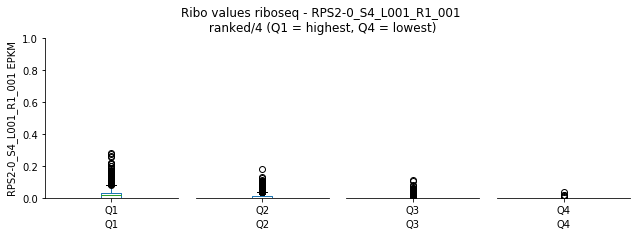

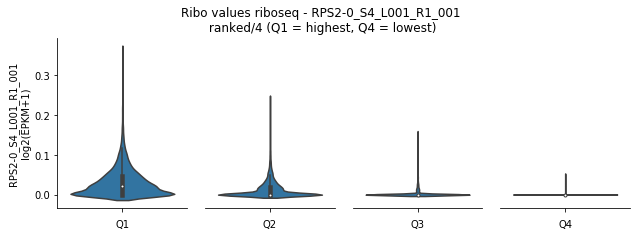

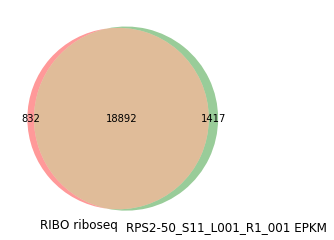

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.1618493598462628
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.04768775781184529
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.031092929490189745


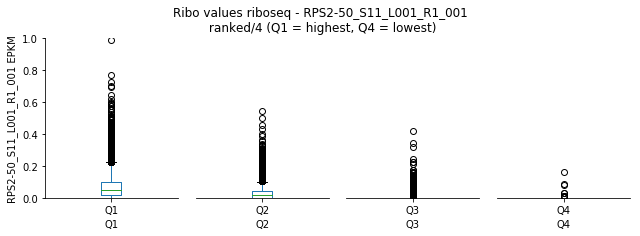

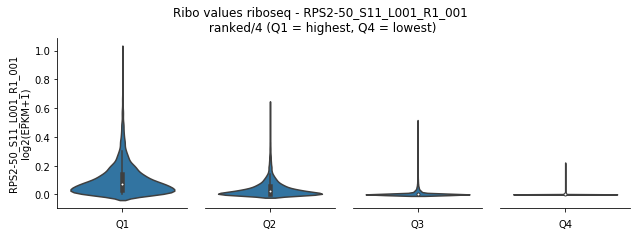

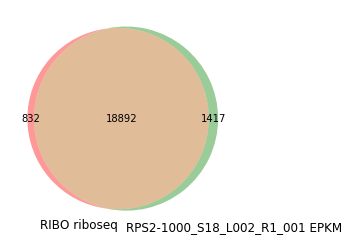

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.4674241971308377
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.21141719442595452
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.11027702237939334


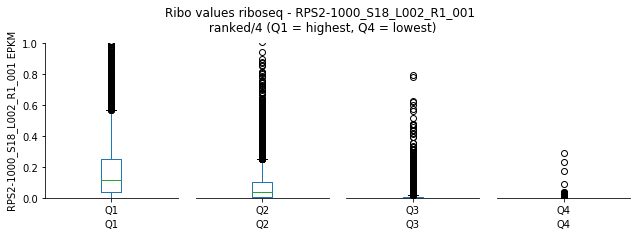

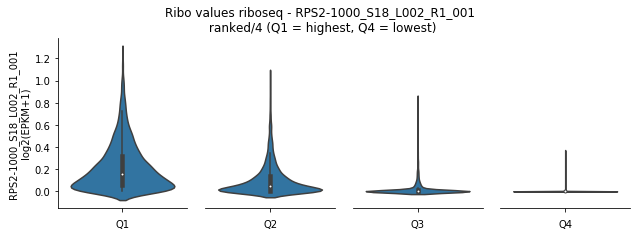

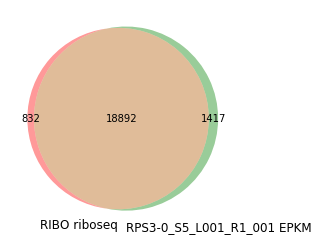

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.0
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.006472083535240594
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.025319207224190548


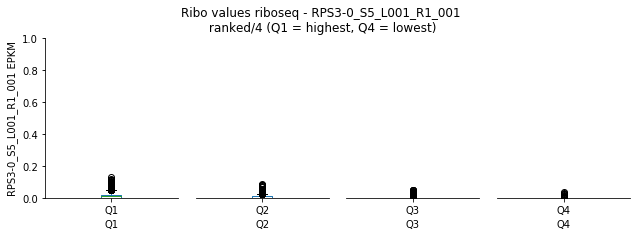

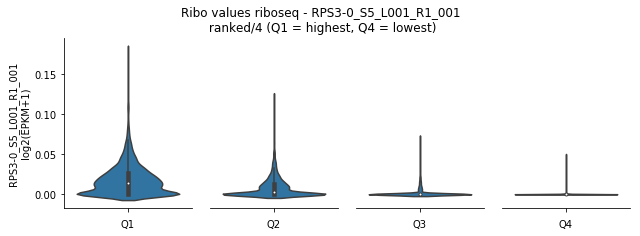

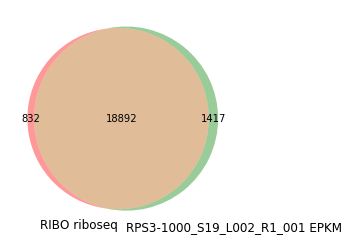

Number of genes in bins:  q1: 4934 q2: 4913 q3: 4856 q4: 5021 
ENSG00000096384 (HSP90AB1) found in q1 w/occupancy value of 1285.5 and EPKM of 0.1215842195028352
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1025.0 and EPKM of 0.07259057842027825
ENSG00000075624 (ACTB) found in q1 w/occupancy value of 1265.5 and EPKM of 0.04302712325569503


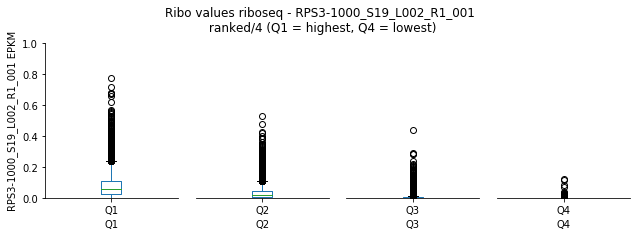

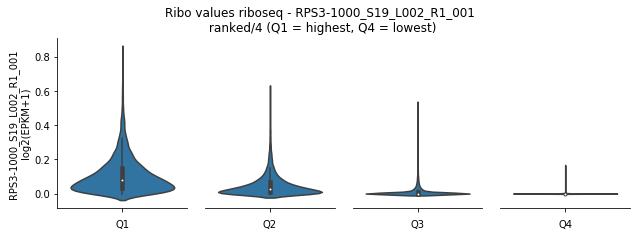

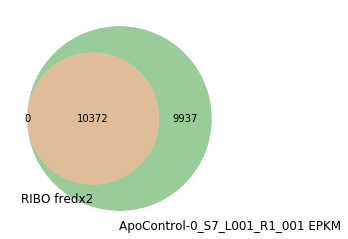

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.008198880301926503
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.007950429383686307
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.042766063044043436


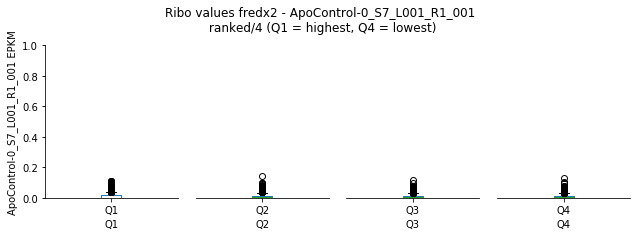

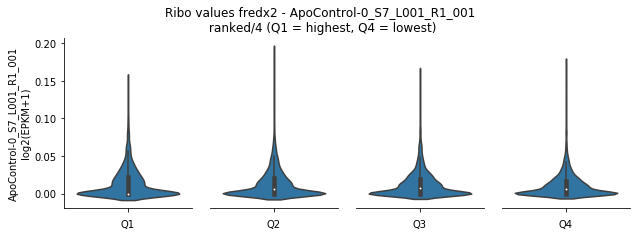

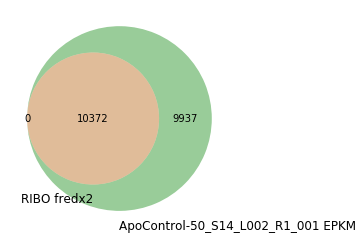

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.009001900093994125
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.04364557621330485
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.011738670792811642


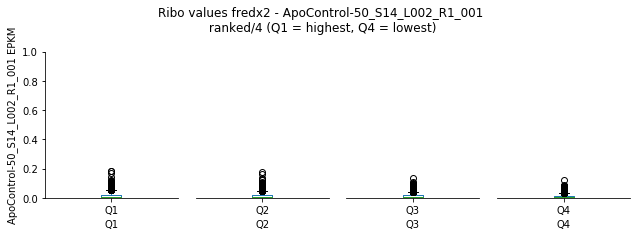

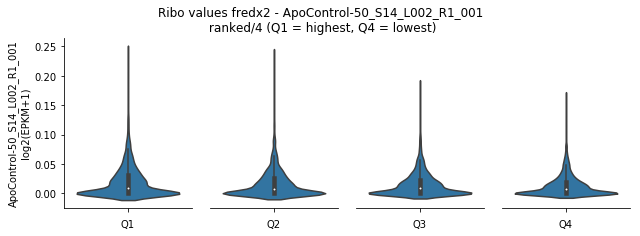

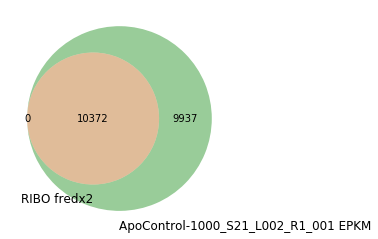

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.007787825769312481
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.022655493147090845
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.0


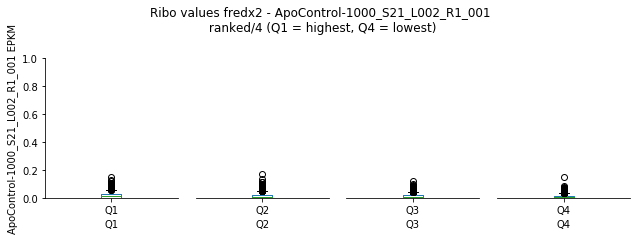

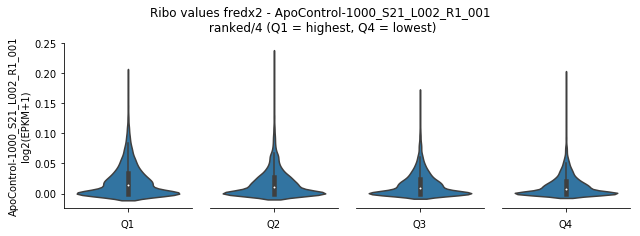

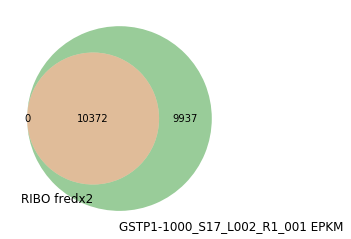

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.01569910211685688
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.0532818011238779
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.020471965870346345


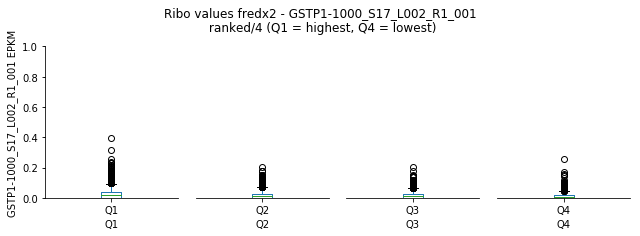

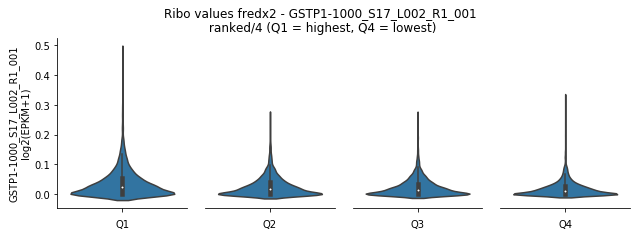

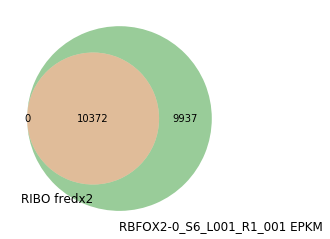

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.00797777055020415
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.0
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.020806367804929213


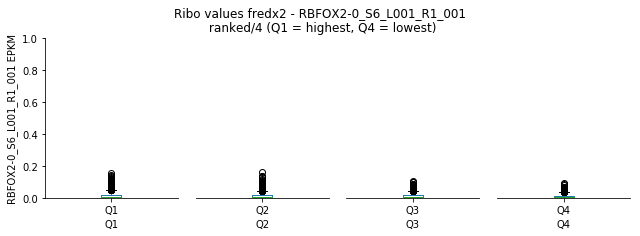

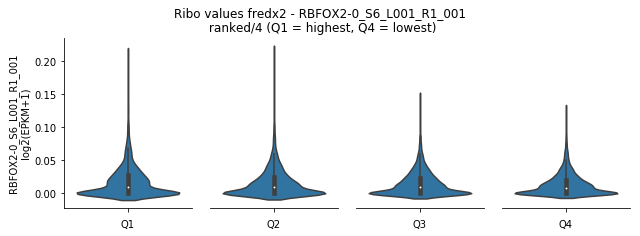

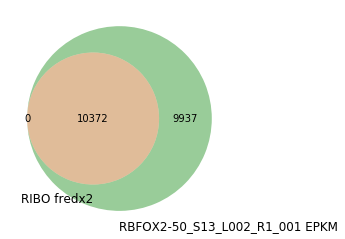

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.05307411459466401
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.12866452022948852
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.0


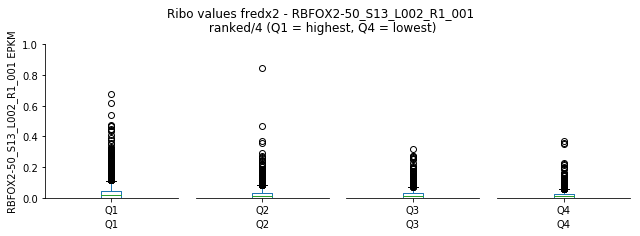

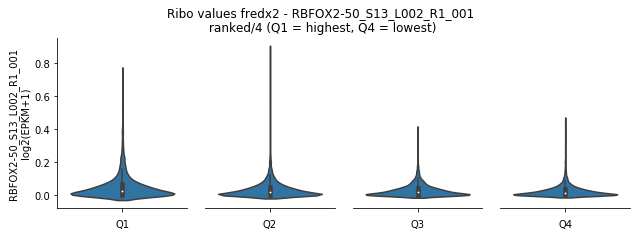

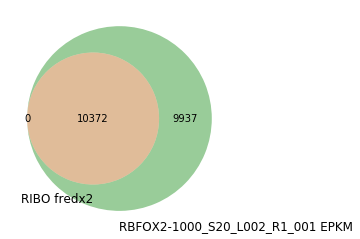

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.07292164325768666
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.14142379298460445
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.019018277362219192


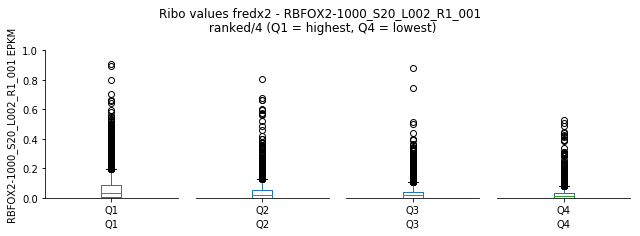

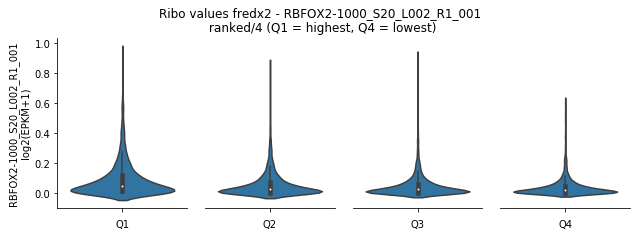

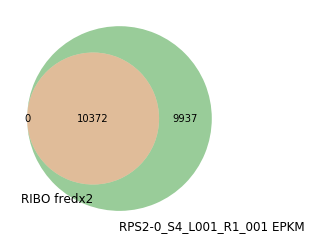

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.042607152232907584
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.04131602640766795
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.06945080042254104


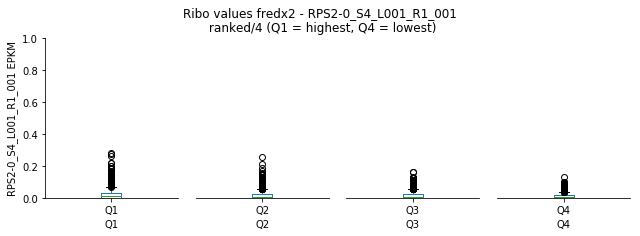

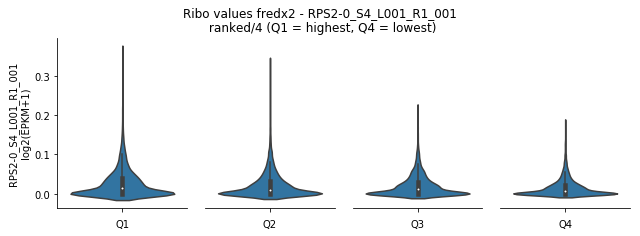

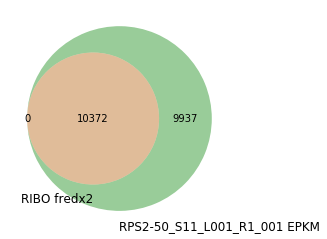

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.04768775781184529
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.1618493598462628
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.031092929490189745


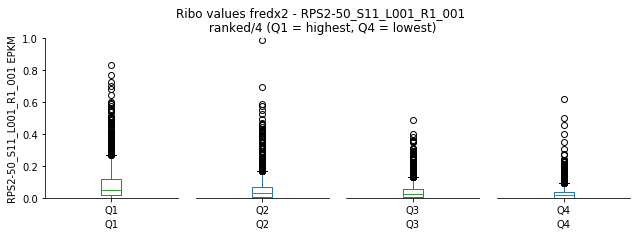

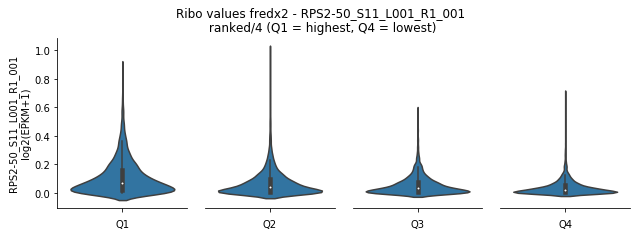

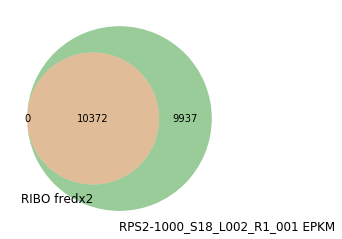

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.21141719442595452
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.4674241971308377
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.11027702237939334


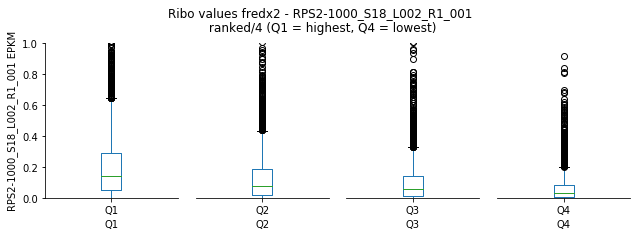

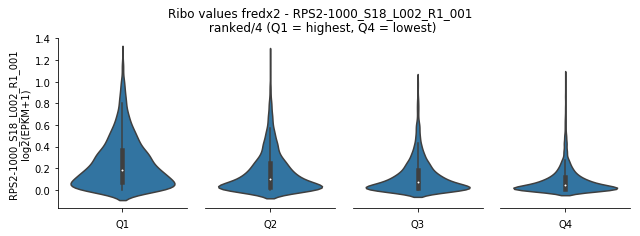

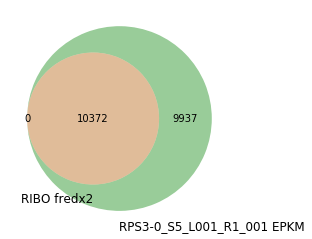

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.006472083535240594
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.0
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.025319207224190548


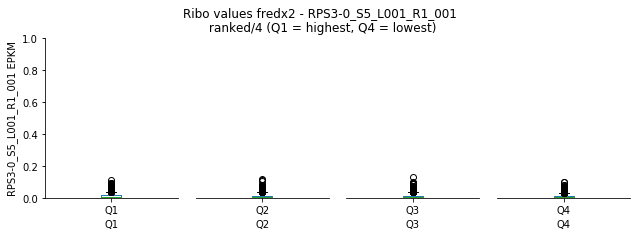

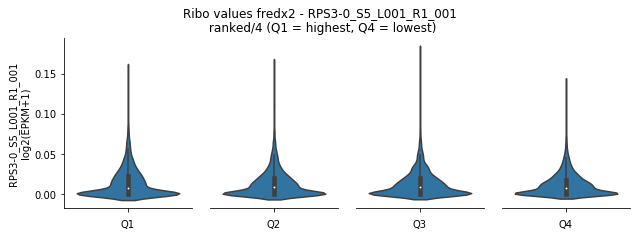

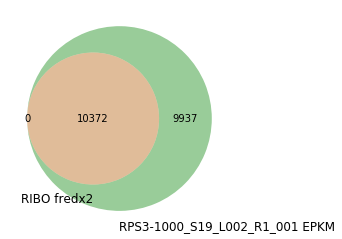

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 1.6744003801368874 and EPKM of 0.07259057842027825
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.7926811038879357 and EPKM of 0.1215842195028352
ENSG00000075624 (ACTB) found in q3 w/occupancy value of 0.6044806695242747 and EPKM of 0.04302712325569503


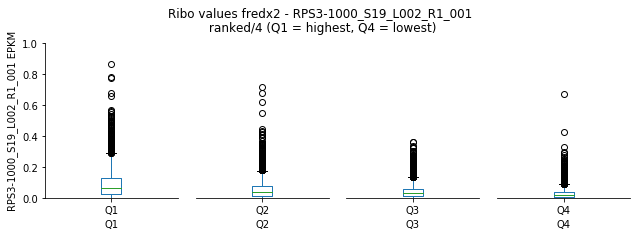

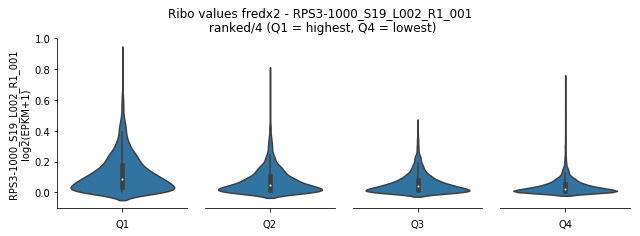

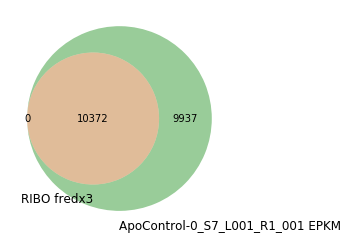

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.008198880301926503
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.007950429383686307
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.042766063044043436


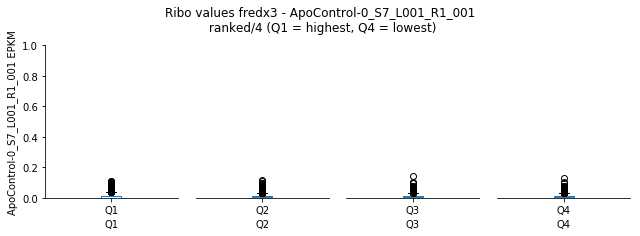

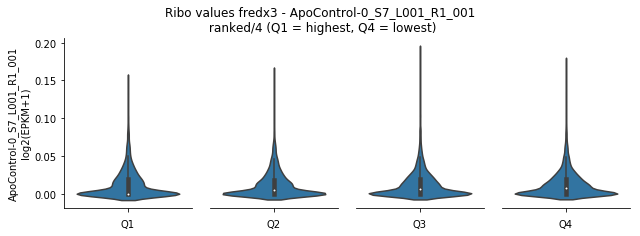

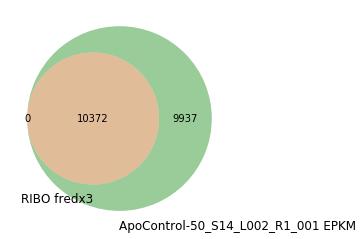

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.009001900093994125
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.04364557621330485
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.011738670792811642


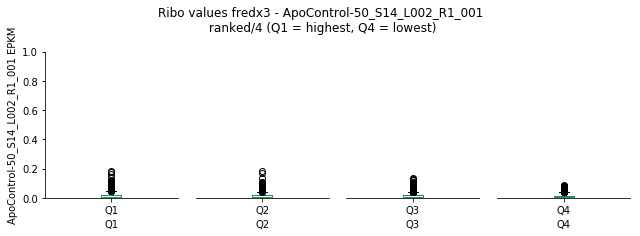

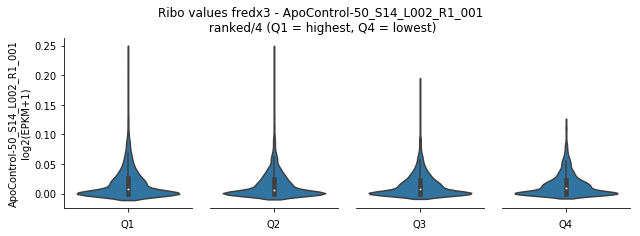

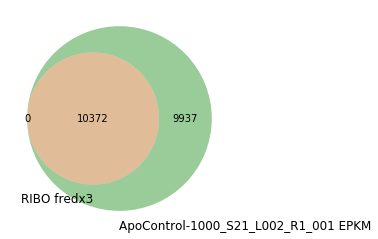

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.007787825769312481
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.022655493147090845
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.0


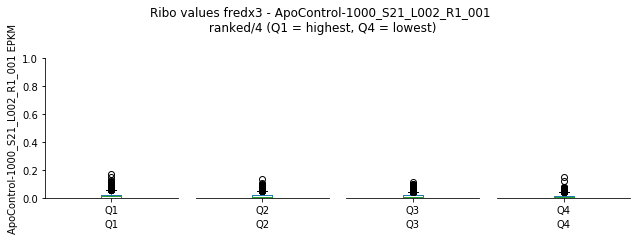

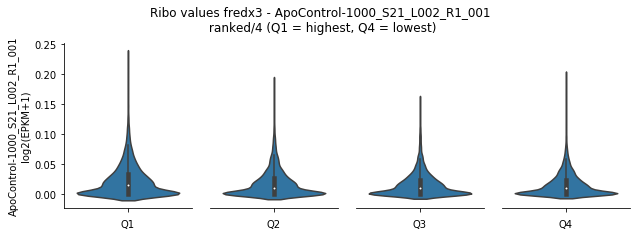

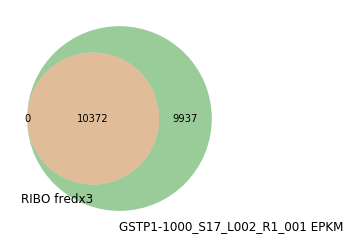

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.01569910211685688
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.0532818011238779
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.020471965870346345


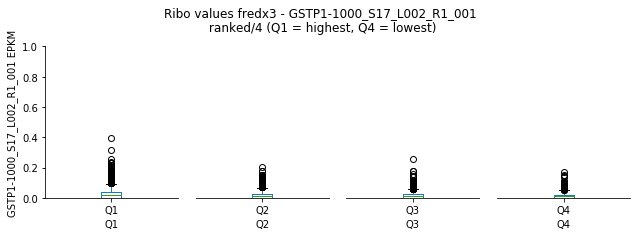

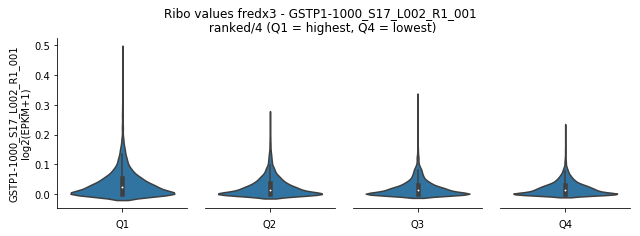

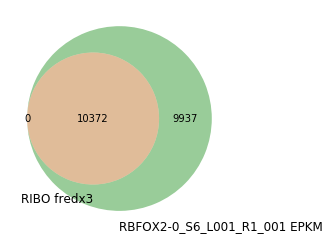

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.00797777055020415
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.0
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.020806367804929213


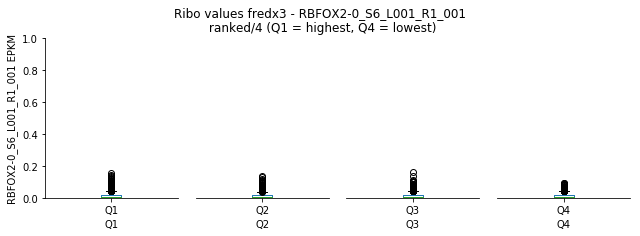

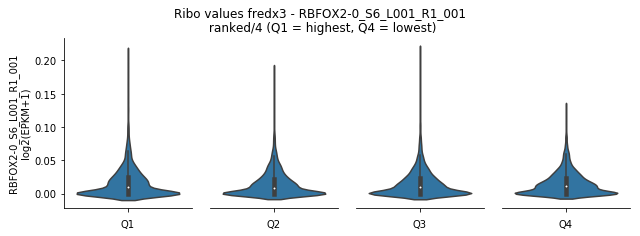

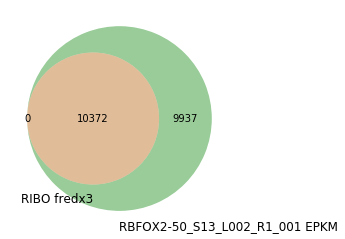

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.05307411459466401
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.12866452022948852
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.0


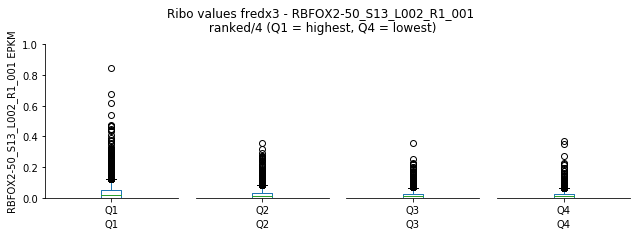

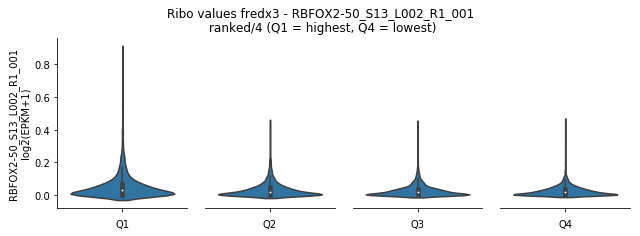

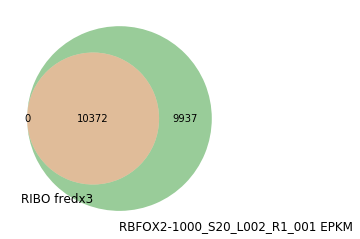

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.07292164325768666
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.14142379298460445
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.019018277362219192


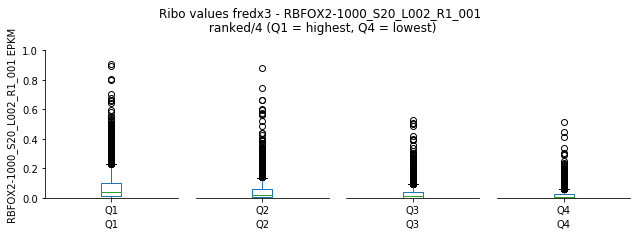

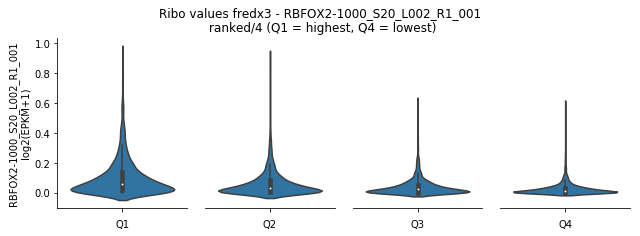

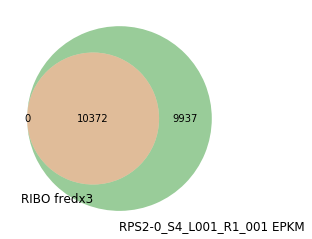

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.042607152232907584
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.04131602640766795
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.06945080042254104


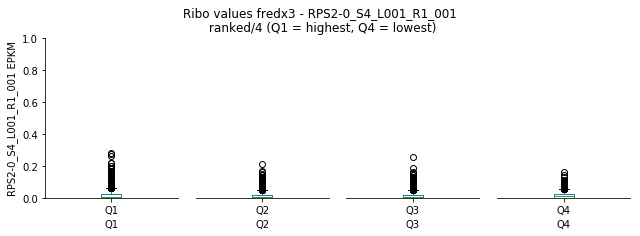

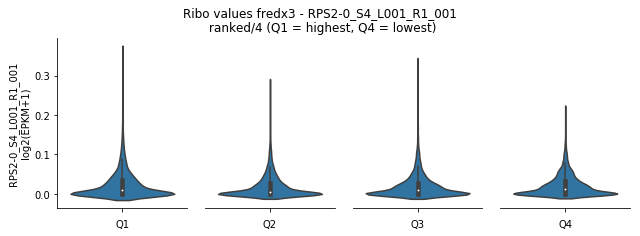

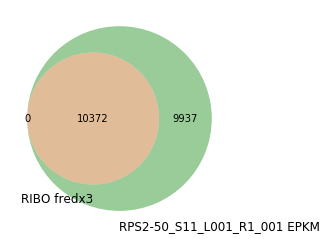

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.04768775781184529
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.1618493598462628
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.031092929490189745


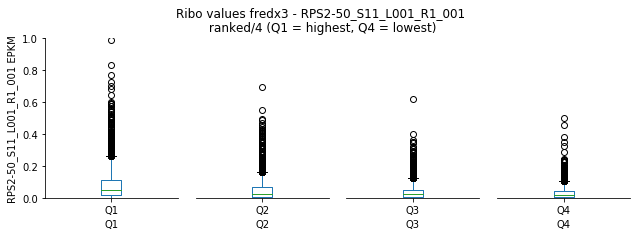

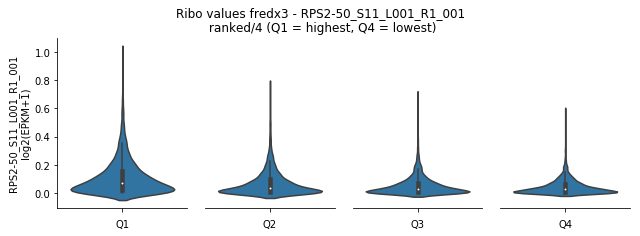

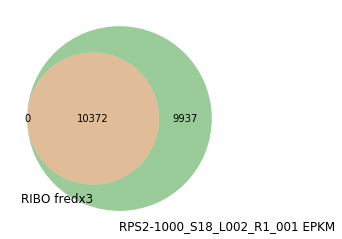

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.21141719442595452
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.4674241971308377
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.11027702237939334


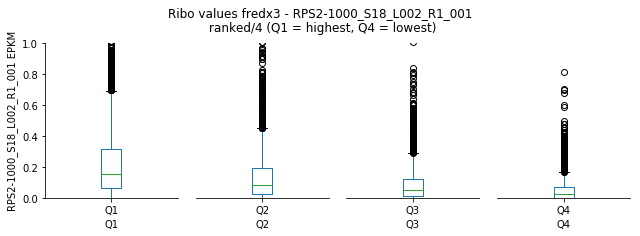

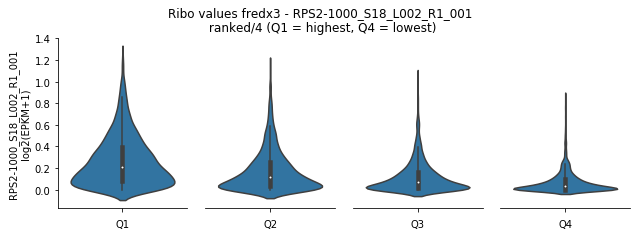

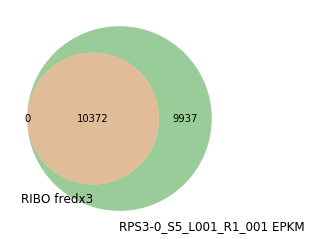

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.006472083535240594
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.0
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.025319207224190548


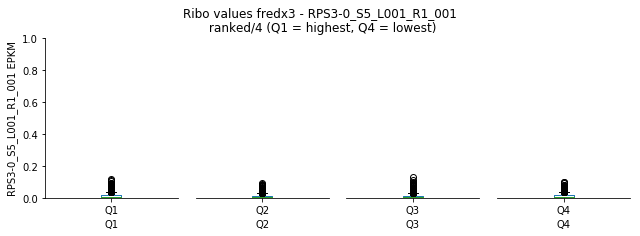

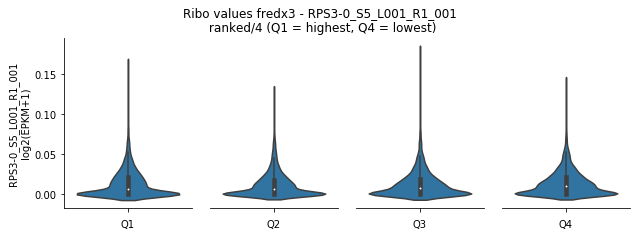

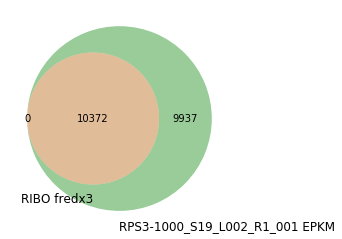

Number of genes in bins:  q1: 2593 q2: 2593 q3: 2593 q4: 2593 
ENSG00000080824 (HSP90AA1) found in q1 w/occupancy value of 2.109330621511916 and EPKM of 0.07259057842027825
ENSG00000096384 (HSP90AB1) found in q2 w/occupancy value of 0.8623493678005536 and EPKM of 0.1215842195028352
ENSG00000075624 (ACTB) found in q4 w/occupancy value of 0.36678448164104677 and EPKM of 0.04302712325569503


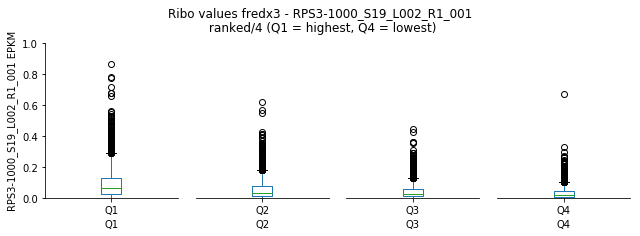

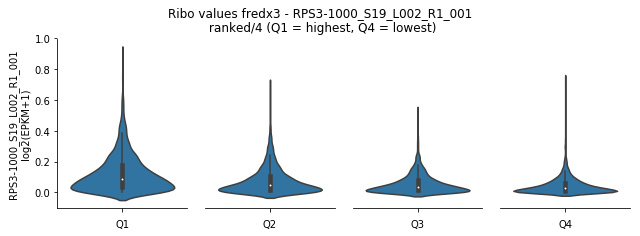

In [36]:
samples = [
    'ApoControl-0_S7_L001_R1_001',
    'ApoControl-50_S14_L002_R1_001',
    'ApoControl-1000_S21_L002_R1_001', 
    'GSTP1-1000_S17_L002_R1_001', 
    'RBFOX2-0_S6_L001_R1_001', 
    'RBFOX2-50_S13_L002_R1_001', 
    'RBFOX2-1000_S20_L002_R1_001',
    'RPS2-0_S4_L001_R1_001',
    'RPS2-50_S11_L001_R1_001',
    'RPS2-1000_S18_L002_R1_001', 
    'RPS3-0_S5_L001_R1_001', 
    'RPS3-1000_S19_L002_R1_001',
]           # edits-per-kilobase-mapped
counts = {'ribolace':ribolace_hek_counts, 'riboseq':riboseq_hek_counts, 'fredx2':fred_x2, 'fredx3':fred_x3}      # ribosome occupancy values

for count_label, count_df in counts.items():
    for samp in samples:
        # slice EPKM table so it only has values associated with the 'samp' label
        epkm_samp = epkm[['Geneid',samp,'gene_type']]
        # convert to ENSEMBL-style annotations
        try:
            epkm_samp['ensembl_Geneid'] = epkm_samp['Geneid'].apply(lambda x: x.split('.')[0])
            del epkm_samp['Geneid']
        except KeyError:
            pass
        epkm_samp.set_index('ensembl_Geneid', inplace=True)
        # only protein coding genes for EPKM table
        epkm_samp = epkm_samp[epkm_samp['gene_type']=='protein_coding']
        # Print a venn of the genes that we're capturing in this analysis. Should have good overlap.
        fig, ax = plt.subplots()
        ax = venn2([set(count_df.index), set(epkm_samp.index)], ['RIBO {}'.format(count_label), '{} EPKM'.format(samp)])
        plt.show()
        plt.close()
        # make a deepcopy so we're not accidentally modifying the referenced variable.
        ribo_occupancy_counts = count_df.copy(deep=True)
        # split into quartiles by ranking their values
        ribo_occupancy_counts['pct'] = ribo_occupancy_counts.rank(pct=True)
        ribo_occupancy_counts.columns = ['avg', 'pct']
        q1 = ribo_occupancy_counts[(ribo_occupancy_counts['pct'] <= 1) & (ribo_occupancy_counts['pct'] > 0.75)][['avg']]
        q2 = ribo_occupancy_counts[(ribo_occupancy_counts['pct'] <= 0.75) & (ribo_occupancy_counts['pct'] > 0.5)][['avg']]
        q3 = ribo_occupancy_counts[(ribo_occupancy_counts['pct'] <= 0.5) & (ribo_occupancy_counts['pct'] > 0.25)][['avg']]
        q4 = ribo_occupancy_counts[(ribo_occupancy_counts['pct'] <= 0.25) & (ribo_occupancy_counts['pct'] > 0.0)][['avg']]
        # Check that the number of elements in each quartile is relatively even (and nothing fishy-looking)
        c = 0
        print("Number of genes in bins: ", sep=' ', end=' ')
        for q in [q1, q2, q3, q4]:
            c += 1
            print("q{}: {}".format(c, q.shape[0]), sep=' ', end=' ')
        print()
        # inner-join (any intersecting ribosome/EPKM value)
        
        ### Plot the boxplot of EPKM values for each quartile ###
        fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
        qs = [q1, q2, q3, q4]
        
        # for each quartile, perform inner join so we're just comparing the genes that exist 
        # in both the current quartile and the epkm table
        for c in range(4):
            merged = pd.merge(qs[c], epkm_samp, how='inner', left_index=True, right_index=True) 
            # Check which quartile kris' examples are in:
            goi = {
                "ENSG00000096384":"HSP90AB1",
                "ENSG00000080824":"HSP90AA1",
                "ENSG00000075624":"ACTB"
            }
            for geneid, genename in goi.items():
                try:
                    print(
                        "{} ({}) found in q{} w/occupancy value of {} and EPKM of {}".format(
                            geneid,
                            genename,
                            c+1,
                            merged.loc[geneid][['avg']].values[0],
                            merged.loc[geneid][[samp]].values[0]
                        )
                    )
                except KeyError: # gene not found in current quartile.
                    pass
            # BOXPLOT CODE!
            merged[samp].plot(kind='box', ax=axs[c], label='Q{}'.format(c+1), ylim=(0, 1))
            # sns.violinplot(merged[samp], ax=axs[c], orient='v', ylim=(0, 1))
            axs[c].set_xlabel('Q{}'.format(c+1))
            sns.despine()
        for c in range(3):
            axs[c+1].get_yaxis().set_visible(False)
            sns.despine(ax=axs[c+1], top=True, bottom=False, left=True, right=True)
        axs[0].set_ylabel('{} EPKM'.format(samp))
        plt.suptitle("Ribo values {} - {}\n ranked/4 (Q1 = highest, Q4 = lowest)".format(count_label, samp), y=1.08)
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, 'boxplot_q_{}_vs_epkm_{}.png'.format(count_label, samp)))
        plt.show()
        plt.close()
        
        ### Plot the boxplot of log2 EPKM values for each quartile ###
        epkm_samp['log2({}+1)'.format(samp)] = np.log2(epkm_samp[samp] + 1)
        fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
        for c in range(4):
            merged = pd.merge(qs[c], epkm_samp, how='left', left_index=True, right_index=True)
            before_size = merged.shape[0]
            merged.dropna(inplace=True)
            after_size = merged.shape[0]
            # print("before/after dropping entries that do not exist in hg19/gencode 19: {} -> {}".format(before_size, after_size))
            # merged['log2({}+1)'.format(samp)].plot(kind='box', ax=axs[c], label='Q{}'.format(c+1), ylim=(0, 1))
            sns.violinplot(merged['log2({}+1)'.format(samp)], ax=axs[c], orient='v', ylim=(0, 1))
            axs[c].set_xlabel('Q{}'.format(c+1))
            sns.despine()
        for c in range(3):
            axs[c+1].get_yaxis().set_visible(False)
            sns.despine(ax=axs[c+1], top=True, bottom=False, left=True, right=True)
        axs[0].set_ylabel('{}\nlog2(EPKM+1)'.format(samp))
        plt.suptitle("Ribo values {} - {}\n ranked/4 (Q1 = highest, Q4 = lowest)".format(count_label, samp), y=1.08)
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, 'boxplot_q_{}_vs_l2epkm_{}.png'.format(count_label, samp)))
        plt.show()
        plt.close()

# Sanity checks

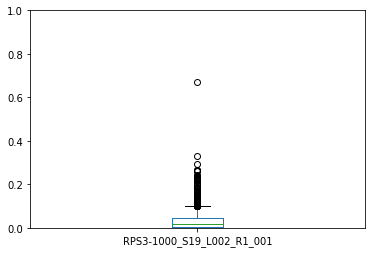

In [37]:
# plot one individually to ensure the plots are correct
merged['RPS3-1000_S19_L002_R1_001'].plot(kind='box', ylim=(0, 1.))

In [38]:
# manually calculate "EPKM" to ensure the EPKM calculations are correct.
epkm[epkm['Geneid'].str.contains('ENSG00000096384')][['RBFOX2-1000_S20_L002_R1_001']]

,RBFOX2-1000_S20_L002_R1_001
19106,0.141424


In [39]:
step_34_output = '/home/bay001/projects/ryan_editing_20190314/permanent_data/34_SAILOR_riboseq/outputs/counts_at_conf_0.9.txt'
ct = pd.read_table(step_34_output, skiprows=1, index_col=0)
del ct['Chr']
del ct['Start']
del ct['End']
ct = ct[['Length','/home/bay001/projects/ryan_editing_20190314/permanent_data/34_SAILOR_riboseq/outputs/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.sorted.bam']]

In [40]:
ct.loc['ENSG00000096384.15']

Length                                                                                                                                                                                                   2796
/home/bay001/projects/ryan_editing_20190314/permanent_data/34_SAILOR_riboseq/outputs/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.sorted.bam      23
Name: ENSG00000096384.15, dtype: int64

### rpkm calculation is: RPKM = numReads / ( geneLength/1000 * totalNumReads/1,000,000 )

In [41]:
23./(2796/1000*56387129/1000000)

0.14588501563883982